In [1]:
# Import notwendiger Bibliotheken
import nussl
from common import data, viz
from IPython.display import Audio
import IPython
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import librosa
import os
from scipy import signal
import matplotlib.pyplot as plt
import stempeg
import pickle
import zipfile
from tensorflow.keras.optimizers import Adam
import tensorflow.signal as tf_signal

c:\Users\Lukas\AppData\Local\Programs\Python\Python38\lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
import tensorflow.signal as tf_signal

# Refactor functions into keras layers.
class InverseSpectrogramLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(InverseSpectrogramLayer, self).__init__(**kwargs)

    def call(self, spect):
        # Convert the input to a tensor if it's not already
        magnitude = tf.convert_to_tensor(spect, dtype=tf.float32)

        # Bestimme die Batch-Größe dynamisch
        batch_size = tf.shape(magnitude)[0]

        # Zielgröße für das Resizing (None, 169, 257)
        target_size = (257, 1723)

        # Resize das Spektrogramm, dabei Batch-Dimension beibehalten
        magnitude_resized = tf.image.resize(magnitude, target_size)  # (None, 169, 257)

        # Falls notwendig, die Dimensionen noch einmal explizit setzen
        magnitude_resized = tf.reshape(magnitude_resized, (batch_size, 257, 1723))

        # Compute complex STFT
        stft_complex = tf.complex(magnitude_resized, tf.zeros_like(magnitude_resized))

        # Perform inverse STFT
        waveform = tf_signal.inverse_stft(stft_complex, frame_length=512, frame_step=254, fft_length=512, window_fn=tf_signal.hann_window)

        waveform = tf.expand_dims(waveform, axis=-1)
        return waveform

class SpectrogramLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SpectrogramLayer, self).__init__(**kwargs)

    def call(self, input_waveform):
        wave = input_waveform[:, :, 0]

        stft = tf_signal.stft(wave, frame_length=512, frame_step=254, fft_length=512, window_fn=tf_signal.hann_window)
        magnitude = tf.abs(stft)  # (Batch, Freq, Time)

        target_size = (512, 128)

        # Umformung für das Resizing: Füge eine Kanal-Dimension hinzu
        magnitude = tf.expand_dims(magnitude, axis=-1)  # (None, 169, 257, 1)

        # Resize das Spektrogramm
        magnitude_resized = tf.image.resize(magnitude, target_size)  # (None, 128, 256, 1)

        # Entferne die zusätzliche Dimension
        magnitude_resized = tf.squeeze(magnitude_resized, axis=-1)  # (None, 128, 256)
        # added tf.expand_dims here so it can be done inside a layer.
        magnitude_resized = tf.expand_dims(magnitude_resized, axis=-1)

        return magnitude_resized  # (None, 128, 256, 1)

In [5]:
drop = 0.45

def build_dual_freq(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)
    print('Input: ', inputs.shape)

    inverse_spectrogram = InverseSpectrogramLayer()
    spectrogram = SpectrogramLayer()

    wave = inverse_spectrogram(inputs)

    # Encoder Spec
    conv1 = layers.Conv2D(64, (5, 5), strides=(4, 1), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(drop)(conv1)
    print('conv1: ', conv1.shape)

    conv2 = layers.Conv2D(128, (5, 5), strides=(4, 1), padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)
    conv2 = layers.Dropout(drop)(conv2)
    print('conv2: ', conv2.shape)

    conv3 = layers.Conv2D(256, (5, 5), strides=(4, 1), padding='same')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    conv3 = layers.Dropout(drop)(conv3)
    print('conv3: ', conv3.shape)

    conv4 = layers.Conv2D(512, (5, 5), strides=(8, 1), padding='same')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.ReLU()(conv4)
    conv4 = layers.Dropout(drop)(conv4)
    print('conv4: ', conv4.shape)

    # Encoder Zeit
    time_conv1 = layers.Conv1D(64, 5, strides=4, padding='same')(wave)
    time_conv1 = layers.BatchNormalization()(time_conv1)
    time_conv1 = layers.ReLU()(time_conv1)
    time_conv1 = layers.Dropout(drop)(time_conv1)
    print('time_conv1: ', time_conv1.shape)

    time_conv2 = layers.Conv1D(128, 5, strides=4, padding='same')(time_conv1)
    time_conv2 = layers.BatchNormalization()(time_conv2)
    time_conv2 = layers.ReLU()(time_conv2)
    time_conv2 = layers.Dropout(drop)(time_conv2)
    print('time_conv2: ', time_conv2.shape)

    time_conv3 = layers.Conv1D(256, 5, strides=4, padding='same')(time_conv2)
    time_conv3 = layers.BatchNormalization()(time_conv3)
    time_conv3 = layers.ReLU()(time_conv3)
    time_conv3 = layers.Dropout(drop)(time_conv3)
    print('time_conv3: ', time_conv3.shape)

    time_conv4 = layers.Conv1D(512, 5, strides=8, padding='same')(time_conv3)
    time_conv4 = layers.BatchNormalization()(time_conv4)
    time_conv4 = layers.ReLU()(time_conv4)
    time_conv4 = layers.Dropout(drop)(time_conv4)
    print('time_conv4: ', time_conv4.shape)

    # Dual Core
    x = layers.Add()([conv4, time_conv4])
    print('x: ', x.shape)

    dual_conv = layers.Conv2D(1024, (5, 5), strides=(1, 2), padding='same')(x)
    dual_conv = layers.BatchNormalization()(dual_conv)
    dual_conv = layers.ReLU()(dual_conv)
    dual_conv = layers.Dropout(drop)(dual_conv)
    print('dual_conv: ', dual_conv.shape)
    #dual_conv = layers.Reshape((64, 1024))(dual_conv)  # Entfernt die unnötige Achse
    #print('dual_conv Reshape: ', dual_conv.shape)

    dual_up = layers.Conv2DTranspose(1024, (5, 5), strides=(1, 2), padding='same')(dual_conv)
    dual_up = layers.BatchNormalization()(dual_up)
    dual_up = layers.ReLU()(dual_up)
    dual_up = layers.Dropout(drop)(dual_up)
    print('dual_up: ', dual_up.shape)
    dual_up_time = layers.Reshape((128, 1024))(dual_up)  # Entfernt die unnötige Achse
    print('dual_up_time Reshape: ', dual_up_time.shape)

    # Decoder Spec
    up6 = layers.Conv2DTranspose(512, (5, 5), strides=(8, 1), padding='same')(dual_up)
    up6 = layers.BatchNormalization()(up6)
    up6 = layers.ReLU()(up6)
    up6 = layers.Dropout(drop)(up6)
    up6 = layers.Concatenate()([up6, conv3])
    print('up6: ', up6.shape)

    up7 = layers.Conv2DTranspose(256, (5, 5), strides=(4, 1), padding='same')(up6)
    up7 = layers.BatchNormalization()(up7)
    up7 = layers.ReLU()(up7)
    up7 = layers.Dropout(drop)(up7)
    up7 = layers.Concatenate()([up7, conv2])
    print('up7: ', up7.shape)

    up8 = layers.Conv2DTranspose(128, (5, 5), strides=(4, 1), padding='same')(up7)
    up8 = layers.BatchNormalization()(up8)
    up8 = layers.ReLU()(up8)
    up8 = layers.Dropout(drop)(up8)
    up8 = layers.Concatenate()([up8, conv1])
    print('up8: ', up8.shape)

    up9 = layers.Conv2DTranspose(64, (5, 5), strides=(4, 1), padding='same')(up8)
    up9 = layers.BatchNormalization()(up9)
    up9 = layers.ReLU()(up9)
    up9 = layers.Dropout(drop)(up9)
    #up9 = layers.Concatenate()([up9, conv1])
    print('up9: ', up9.shape)

    # Decoder Spec
    time_up6 = layers.Conv1DTranspose(512, 5, strides=8, padding='same')(dual_up_time)
    time_up6 = layers.BatchNormalization()(time_up6)
    time_up6 = layers.ReLU()(time_up6)
    time_up6 = layers.Dropout(drop)(time_up6)
    time_up6 = layers.Concatenate()([time_up6, time_conv3])
    print('time_up6: ', time_up6.shape)

    time_up7 = layers.Conv1DTranspose(256, 5, strides=4, padding='same')(time_up6)
    time_up7 = layers.BatchNormalization()(time_up7)
    time_up7 = layers.ReLU()(time_up7)
    time_up7 = layers.Dropout(drop)(time_up7)
    time_up7 = layers.Concatenate()([time_up7, time_conv2])
    print('time_up7: ', time_up7.shape)

    time_up8 = layers.Conv1DTranspose(128, 5, strides=4, padding='same')(time_up7)
    time_up8 = layers.BatchNormalization()(time_up8)
    time_up8 = layers.ReLU()(time_up8)
    time_up8 = layers.Dropout(drop)(time_up8)
    time_up8 = layers.Concatenate()([time_up8, time_conv1])
    print('time_up8: ', time_up8.shape)

    time_up9 = layers.Conv1DTranspose(64, 5, strides=4, padding='same')(time_up8)
    time_up9 = layers.BatchNormalization()(time_up9)
    time_up9 = layers.ReLU()(time_up9)
    time_up9 = layers.Dropout(drop)(time_up9)
    #time_up9 = layers.Concatenate()([time_up9, time_conv1])
    print('time_up9: ', time_up9.shape)

    spect = spectrogram(time_up9)
    print('spect: ', spect.shape)
    #spect = tf.expand_dims(spect, axis=-1)
    print('spect expanded: ', spect.shape)

    y = layers.Add()([spect, up9])
    print('y: ', y.shape)

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', activation='sigmoid')(y)
    #outputs = y
    print('outputs: ', outputs.shape)

    model = tf.keras.Model(inputs, outputs)
    return model

def build_dual_freq2(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)
    print('Input: ', inputs.shape)

    inverse_spectrogram = InverseSpectrogramLayer()
    spectrogram = SpectrogramLayer()

    wave = inverse_spectrogram(inputs)

    # Encoder Spec
    conv1 = layers.Conv2D(64, (5, 5), strides=(4, 1), padding='same')(inputs)
    #conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(drop)(conv1)
    print('conv1: ', conv1.shape)

    conv2 = layers.Conv2D(128, (5, 5), strides=(4, 1), padding='same')(conv1)
    #conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)
    conv2 = layers.Dropout(drop)(conv2)
    print('conv2: ', conv2.shape)

    conv3 = layers.Conv2D(256, (5, 5), strides=(4, 1), padding='same')(conv2)
    #conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    conv3 = layers.Dropout(drop)(conv3)
    print('conv3: ', conv3.shape)

    conv4 = layers.Conv2D(512, (5, 5), strides=(8, 1), padding='same')(conv3)
    #conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.ReLU()(conv4)
    conv4 = layers.Dropout(drop)(conv4)
    print('conv4: ', conv4.shape)

    # Encoder Zeit
    time_conv1 = layers.Conv1D(64, 5, strides=4, padding='same')(wave)
    #time_conv1 = layers.BatchNormalization()(time_conv1)
    time_conv1 = layers.ReLU()(time_conv1)
    time_conv1 = layers.Dropout(drop)(time_conv1)
    print('time_conv1: ', time_conv1.shape)

    time_conv2 = layers.Conv1D(128, 5, strides=4, padding='same')(time_conv1)
    #time_conv2 = layers.BatchNormalization()(time_conv2)
    time_conv2 = layers.ReLU()(time_conv2)
    time_conv2 = layers.Dropout(drop)(time_conv2)
    print('time_conv2: ', time_conv2.shape)

    time_conv3 = layers.Conv1D(256, 5, strides=4, padding='same')(time_conv2)
    #time_conv3 = layers.BatchNormalization()(time_conv3)
    time_conv3 = layers.ReLU()(time_conv3)
    time_conv3 = layers.Dropout(drop)(time_conv3)
    print('time_conv3: ', time_conv3.shape)

    time_conv4 = layers.Conv1D(512, 5, strides=8, padding='same')(time_conv3)
    #time_conv4 = layers.BatchNormalization()(time_conv4)
    time_conv4 = layers.ReLU()(time_conv4)
    time_conv4 = layers.Dropout(drop)(time_conv4)
    print('time_conv4: ', time_conv4.shape)

    # Dual Core
    x = layers.Add()([conv4, time_conv4])
    print('x: ', x.shape)

    dual_conv = layers.Conv2D(1024, (5, 5), strides=(1, 2), padding='same')(x)
    #dual_conv = layers.BatchNormalization()(dual_conv)
    dual_conv = layers.ReLU()(dual_conv)
    dual_conv = layers.Dropout(drop)(dual_conv)
    print('dual_conv: ', dual_conv.shape)
    #dual_conv = layers.Reshape((64, 1024))(dual_conv)  # Entfernt die unnötige Achse
    #print('dual_conv Reshape: ', dual_conv.shape)

    dual_up = layers.Conv2DTranspose(1024, (5, 5), strides=(1, 2), padding='same')(dual_conv)
    #dual_up = layers.BatchNormalization()(dual_up)
    dual_up = layers.ReLU()(dual_up)
    dual_up = layers.Dropout(drop)(dual_up)
    print('dual_up: ', dual_up.shape)
    dual_up_time = layers.Reshape((128, 1024))(dual_up)  # Entfernt die unnötige Achse
    print('dual_up_time Reshape: ', dual_up_time.shape)

    # Decoder Spec
    up6 = layers.Conv2DTranspose(512, (5, 5), strides=(8, 1), padding='same')(dual_up)
    #up6 = layers.BatchNormalization()(up6)
    up6 = layers.ReLU()(up6)
    up6 = layers.Dropout(drop)(up6)
    up6 = layers.Concatenate()([up6, conv3])
    print('up6: ', up6.shape)

    up7 = layers.Conv2DTranspose(256, (5, 5), strides=(4, 1), padding='same')(up6)
    #up7 = layers.BatchNormalization()(up7)
    up7 = layers.ReLU()(up7)
    up7 = layers.Dropout(drop)(up7)
    up7 = layers.Concatenate()([up7, conv2])
    print('up7: ', up7.shape)

    up8 = layers.Conv2DTranspose(128, (5, 5), strides=(4, 1), padding='same')(up7)
    #up8 = layers.BatchNormalization()(up8)
    up8 = layers.ReLU()(up8)
    up8 = layers.Dropout(drop)(up8)
    up8 = layers.Concatenate()([up8, conv1])
    print('up8: ', up8.shape)

    up9 = layers.Conv2DTranspose(64, (5, 5), strides=(4, 1), padding='same')(up8)
    #up9 = layers.BatchNormalization()(up9)
    up9 = layers.ReLU()(up9)
    up9 = layers.Dropout(drop)(up9)
    #up9 = layers.Concatenate()([up9, conv1])
    print('up9: ', up9.shape)

    # Decoder Spec
    time_up6 = layers.Conv1DTranspose(512, 5, strides=8, padding='same')(dual_up_time)
    #time_up6 = layers.BatchNormalization()(time_up6)
    time_up6 = layers.ReLU()(time_up6)
    time_up6 = layers.Dropout(drop)(time_up6)
    time_up6 = layers.Concatenate()([time_up6, time_conv3])
    print('time_up6: ', time_up6.shape)

    time_up7 = layers.Conv1DTranspose(256, 5, strides=4, padding='same')(time_up6)
    #time_up7 = layers.BatchNormalization()(time_up7)
    time_up7 = layers.ReLU()(time_up7)
    time_up7 = layers.Dropout(drop)(time_up7)
    time_up7 = layers.Concatenate()([time_up7, time_conv2])
    print('time_up7: ', time_up7.shape)

    time_up8 = layers.Conv1DTranspose(128, 5, strides=4, padding='same')(time_up7)
    #time_up8 = layers.BatchNormalization()(time_up8)
    time_up8 = layers.ReLU()(time_up8)
    time_up8 = layers.Dropout(drop)(time_up8)
    time_up8 = layers.Concatenate()([time_up8, time_conv1])
    print('time_up8: ', time_up8.shape)

    time_up9 = layers.Conv1DTranspose(64, 5, strides=4, padding='same')(time_up8)
    #time_up9 = layers.BatchNormalization()(time_up9)
    time_up9 = layers.ReLU()(time_up9)
    time_up9 = layers.Dropout(drop)(time_up9)
    #time_up9 = layers.Concatenate()([time_up9, time_conv1])
    print('time_up9: ', time_up9.shape)

    spect = spectrogram(time_up9)
    print('spect: ', spect.shape)
    #spect = tf.expand_dims(spect, axis=-1)
    print('spect expanded: ', spect.shape)

    y = layers.Add()([spect, up9])
    print('y: ', y.shape)

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', activation='sigmoid')(y)
    #outputs = y
    print('outputs: ', outputs.shape)

    model = tf.keras.Model(inputs, outputs)
    return model


def build_dual_freq_Gelu_linear2(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)
    print('Input: ', inputs.shape)

    inverse_spectrogram = InverseSpectrogramLayer()
    spectrogram = SpectrogramLayer()

    wave = inverse_spectrogram(inputs)

    # Encoder Spec
    conv1 = layers.Conv2D(64, (5, 5), strides=(4, 1), padding='same')(inputs)
    #conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation("gelu")(conv1)
    conv1 = layers.Dropout(drop)(conv1)
    print('conv1: ', conv1.shape)

    conv2 = layers.Conv2D(128, (5, 5), strides=(4, 1), padding='same')(conv1)
    #conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation("gelu")(conv2)
    conv2 = layers.Dropout(drop)(conv2)
    print('conv2: ', conv2.shape)

    conv3 = layers.Conv2D(256, (5, 5), strides=(4, 1), padding='same')(conv2)
    #conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation("gelu")(conv3)
    conv3 = layers.Dropout(drop)(conv3)
    print('conv3: ', conv3.shape)

    conv4 = layers.Conv2D(512, (5, 5), strides=(8, 1), padding='same')(conv3)
    #conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation("gelu")(conv4)
    conv4 = layers.Dropout(drop)(conv4)
    print('conv4: ', conv4.shape)

    # Encoder Zeit
    time_conv1 = layers.Conv1D(64, 5, strides=4, padding='same')(wave)
    #time_conv1 = layers.BatchNormalization()(time_conv1)
    time_conv1 = layers.Activation("gelu")(time_conv1)
    time_conv1 = layers.Dropout(drop)(time_conv1)
    print('time_conv1: ', time_conv1.shape)

    time_conv2 = layers.Conv1D(128, 5, strides=4, padding='same')(time_conv1)
    #time_conv2 = layers.BatchNormalization()(time_conv2)
    time_conv2 = layers.Activation("gelu")(time_conv2)
    time_conv2 = layers.Dropout(drop)(time_conv2)
    print('time_conv2: ', time_conv2.shape)

    time_conv3 = layers.Conv1D(256, 5, strides=4, padding='same')(time_conv2)
    #time_conv3 = layers.BatchNormalization()(time_conv3)
    time_conv3 = layers.Activation("gelu")(time_conv3)
    time_conv3 = layers.Dropout(drop)(time_conv3)
    print('time_conv3: ', time_conv3.shape)

    time_conv4 = layers.Conv1D(512, 5, strides=8, padding='same')(time_conv3)
    #time_conv4 = layers.BatchNormalization()(time_conv4)
    time_conv4 = layers.Activation("gelu")(time_conv4)
    time_conv4 = layers.Dropout(drop)(time_conv4)
    print('time_conv4: ', time_conv4.shape)

    # Dual Core
    x = layers.Add()([conv4, time_conv4])
    print('x: ', x.shape)

    dual_conv = layers.Conv2D(1024, (5, 5), strides=(1, 2), padding='same')(x)
    dual_conv = layers.BatchNormalization()(dual_conv)
    dual_conv = layers.Activation("gelu")(dual_conv)
    dual_conv = layers.Dropout(drop)(dual_conv)
    print('dual_conv: ', dual_conv.shape)
    #dual_conv = layers.Reshape((64, 1024))(dual_conv)  # Entfernt die unnötige Achse
    #print('dual_conv Reshape: ', dual_conv.shape)

    dual_up = layers.Conv2DTranspose(1024, (5, 5), strides=(1, 2), padding='same')(dual_conv)
    dual_up = layers.BatchNormalization()(dual_up)
    dual_up = layers.Activation("gelu")(dual_up)
    dual_up = layers.Dropout(drop)(dual_up)
    print('dual_up: ', dual_up.shape)
    dual_up_time = layers.Reshape((128, 1024))(dual_up)  # Entfernt die unnötige Achse
    print('dual_up_time Reshape: ', dual_up_time.shape)

    # Decoder Spec
    up6 = layers.Conv2DTranspose(512, (5, 5), strides=(8, 1), padding='same')(dual_up)
    #up6 = layers.BatchNormalization()(up6)
    up6 = layers.Activation("gelu")(up6)
    up6 = layers.Dropout(drop)(up6)
    up6 = layers.Concatenate()([up6, conv3])
    print('up6: ', up6.shape)

    up7 = layers.Conv2DTranspose(256, (5, 5), strides=(4, 1), padding='same')(up6)
    #up7 = layers.BatchNormalization()(up7)
    up7 = layers.Activation("gelu")(up7)
    up7 = layers.Dropout(drop)(up7)
    up7 = layers.Concatenate()([up7, conv2])
    print('up7: ', up7.shape)

    up8 = layers.Conv2DTranspose(128, (5, 5), strides=(4, 1), padding='same')(up7)
    #up8 = layers.BatchNormalization()(up8)
    up8 = layers.Activation("gelu")(up8)
    up8 = layers.Dropout(drop)(up8)
    up8 = layers.Concatenate()([up8, conv1])
    print('up8: ', up8.shape)

    up9 = layers.Conv2DTranspose(64, (5, 5), strides=(4, 1), padding='same')(up8)
    #up9 = layers.BatchNormalization()(up9)
    up9 = layers.Activation("gelu")(up9)
    up9 = layers.Dropout(drop)(up9)
    #up9 = layers.Concatenate()([up9, conv1])
    print('up9: ', up9.shape)

    # Decoder Spec
    time_up6 = layers.Conv1DTranspose(512, 5, strides=8, padding='same')(dual_up_time)
    #time_up6 = layers.BatchNormalization()(time_up6)
    time_up6 = layers.Activation("gelu")(time_up6)
    time_up6 = layers.Dropout(drop)(time_up6)
    time_up6 = layers.Concatenate()([time_up6, time_conv3])
    print('time_up6: ', time_up6.shape)

    time_up7 = layers.Conv1DTranspose(256, 5, strides=4, padding='same')(time_up6)
    #time_up7 = layers.BatchNormalization()(time_up7)
    time_up7 = layers.Activation("gelu")(time_up7)
    time_up7 = layers.Dropout(drop)(time_up7)
    time_up7 = layers.Concatenate()([time_up7, time_conv2])
    print('time_up7: ', time_up7.shape)

    time_up8 = layers.Conv1DTranspose(128, 5, strides=4, padding='same')(time_up7)
    #time_up8 = layers.BatchNormalization()(time_up8)
    time_up8 = layers.Activation("gelu")(time_up8)
    time_up8 = layers.Dropout(drop)(time_up8)
    time_up8 = layers.Concatenate()([time_up8, time_conv1])
    print('time_up8: ', time_up8.shape)

    time_up9 = layers.Conv1DTranspose(64, 5, strides=4, padding='same')(time_up8)
    #time_up9 = layers.BatchNormalization()(time_up9)
    time_up9 = layers.Activation("gelu")(time_up9)
    time_up9 = layers.Dropout(drop)(time_up9)
    #time_up9 = layers.Concatenate()([time_up9, time_conv1])
    print('time_up9: ', time_up9.shape)

    spect = spectrogram(time_up9)
    print('spect: ', spect.shape)
    #spect = tf.expand_dims(spect, axis=-1)
    print('spect expanded: ', spect.shape)

    y = layers.Add()([spect, up9])
    print('y: ', y.shape)

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', activation='linear')(y)
    #outputs = y
    print('outputs: ', outputs.shape)

    model = tf.keras.Model(inputs, outputs)
    return model


def build_dual_freq_Gelu2(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)
    print('Input: ', inputs.shape)

    inverse_spectrogram = InverseSpectrogramLayer()
    spectrogram = SpectrogramLayer()

    wave = inverse_spectrogram(inputs)

    # Encoder Spec
    conv1 = layers.Conv2D(64, (5, 5), strides=(4, 1), padding='same')(inputs)
    #conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation("gelu")(conv1)
    conv1 = layers.Dropout(drop)(conv1)
    print('conv1: ', conv1.shape)

    conv2 = layers.Conv2D(128, (5, 5), strides=(4, 1), padding='same')(conv1)
    #conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation("gelu")(conv2)
    conv2 = layers.Dropout(drop)(conv2)
    print('conv2: ', conv2.shape)

    conv3 = layers.Conv2D(256, (5, 5), strides=(4, 1), padding='same')(conv2)
    #conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation("gelu")(conv3)
    conv3 = layers.Dropout(drop)(conv3)
    print('conv3: ', conv3.shape)

    conv4 = layers.Conv2D(512, (5, 5), strides=(8, 1), padding='same')(conv3)
    #conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation("gelu")(conv4)
    conv4 = layers.Dropout(drop)(conv4)
    print('conv4: ', conv4.shape)

    # Encoder Zeit
    time_conv1 = layers.Conv1D(64, 5, strides=4, padding='same')(wave)
    #time_conv1 = layers.BatchNormalization()(time_conv1)
    time_conv1 = layers.Activation("gelu")(time_conv1)
    time_conv1 = layers.Dropout(drop)(time_conv1)
    print('time_conv1: ', time_conv1.shape)

    time_conv2 = layers.Conv1D(128, 5, strides=4, padding='same')(time_conv1)
    #time_conv2 = layers.BatchNormalization()(time_conv2)
    time_conv2 = layers.Activation("gelu")(time_conv2)
    time_conv2 = layers.Dropout(drop)(time_conv2)
    print('time_conv2: ', time_conv2.shape)

    time_conv3 = layers.Conv1D(256, 5, strides=4, padding='same')(time_conv2)
    #time_conv3 = layers.BatchNormalization()(time_conv3)
    time_conv3 = layers.Activation("gelu")(time_conv3)
    time_conv3 = layers.Dropout(drop)(time_conv3)
    print('time_conv3: ', time_conv3.shape)

    time_conv4 = layers.Conv1D(512, 5, strides=8, padding='same')(time_conv3)
    #time_conv4 = layers.BatchNormalization()(time_conv4)
    time_conv4 = layers.Activation("gelu")(time_conv4)
    time_conv4 = layers.Dropout(drop)(time_conv4)
    print('time_conv4: ', time_conv4.shape)

    # Dual Core
    x = layers.Add()([conv4, time_conv4])
    print('x: ', x.shape)

    dual_conv = layers.Conv2D(1024, (5, 5), strides=(1, 2), padding='same')(x)
    dual_conv = layers.BatchNormalization()(dual_conv)
    dual_conv = layers.Activation("gelu")(dual_conv)
    dual_conv = layers.Dropout(drop)(dual_conv)
    print('dual_conv: ', dual_conv.shape)
    #dual_conv = layers.Reshape((64, 1024))(dual_conv)  # Entfernt die unnötige Achse
    #print('dual_conv Reshape: ', dual_conv.shape)

    dual_up = layers.Conv2DTranspose(1024, (5, 5), strides=(1, 2), padding='same')(dual_conv)
    dual_up = layers.BatchNormalization()(dual_up)
    dual_up = layers.Activation("gelu")(dual_up)
    dual_up = layers.Dropout(drop)(dual_up)
    print('dual_up: ', dual_up.shape)
    dual_up_time = layers.Reshape((128, 1024))(dual_up)  # Entfernt die unnötige Achse
    print('dual_up_time Reshape: ', dual_up_time.shape)

    # Decoder Spec
    up6 = layers.Conv2DTranspose(512, (5, 5), strides=(8, 1), padding='same')(dual_up)
    #up6 = layers.BatchNormalization()(up6)
    up6 = layers.Activation("gelu")(up6)
    up6 = layers.Dropout(drop)(up6)
    up6 = layers.Concatenate()([up6, conv3])
    print('up6: ', up6.shape)

    up7 = layers.Conv2DTranspose(256, (5, 5), strides=(4, 1), padding='same')(up6)
    #up7 = layers.BatchNormalization()(up7)
    up7 = layers.Activation("gelu")(up7)
    up7 = layers.Dropout(drop)(up7)
    up7 = layers.Concatenate()([up7, conv2])
    print('up7: ', up7.shape)

    up8 = layers.Conv2DTranspose(128, (5, 5), strides=(4, 1), padding='same')(up7)
    #up8 = layers.BatchNormalization()(up8)
    up8 = layers.Activation("gelu")(up8)
    up8 = layers.Dropout(drop)(up8)
    up8 = layers.Concatenate()([up8, conv1])
    print('up8: ', up8.shape)

    up9 = layers.Conv2DTranspose(64, (5, 5), strides=(4, 1), padding='same')(up8)
    #up9 = layers.BatchNormalization()(up9)
    up9 = layers.Activation("gelu")(up9)
    up9 = layers.Dropout(drop)(up9)
    #up9 = layers.Concatenate()([up9, conv1])
    print('up9: ', up9.shape)

    # Decoder Spec
    time_up6 = layers.Conv1DTranspose(512, 5, strides=8, padding='same')(dual_up_time)
    #time_up6 = layers.BatchNormalization()(time_up6)
    time_up6 = layers.Activation("gelu")(time_up6)
    time_up6 = layers.Dropout(drop)(time_up6)
    time_up6 = layers.Concatenate()([time_up6, time_conv3])
    print('time_up6: ', time_up6.shape)

    time_up7 = layers.Conv1DTranspose(256, 5, strides=4, padding='same')(time_up6)
    #time_up7 = layers.BatchNormalization()(time_up7)
    time_up7 = layers.Activation("gelu")(time_up7)
    time_up7 = layers.Dropout(drop)(time_up7)
    time_up7 = layers.Concatenate()([time_up7, time_conv2])
    print('time_up7: ', time_up7.shape)

    time_up8 = layers.Conv1DTranspose(128, 5, strides=4, padding='same')(time_up7)
    #time_up8 = layers.BatchNormalization()(time_up8)
    time_up8 = layers.Activation("gelu")(time_up8)
    time_up8 = layers.Dropout(drop)(time_up8)
    time_up8 = layers.Concatenate()([time_up8, time_conv1])
    print('time_up8: ', time_up8.shape)

    time_up9 = layers.Conv1DTranspose(64, 5, strides=4, padding='same')(time_up8)
    #time_up9 = layers.BatchNormalization()(time_up9)
    time_up9 = layers.Activation("gelu")(time_up9)
    time_up9 = layers.Dropout(drop)(time_up9)
    #time_up9 = layers.Concatenate()([time_up9, time_conv1])
    print('time_up9: ', time_up9.shape)

    spect = spectrogram(time_up9)
    print('spect: ', spect.shape)
    #spect = tf.expand_dims(spect, axis=-1)
    print('spect expanded: ', spect.shape)

    y = layers.Add()([spect, up9])
    print('y: ', y.shape)

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', activation='sigmoid')(y)
    #outputs = y
    print('outputs: ', outputs.shape)

    model = tf.keras.Model(inputs, outputs)
    return model

def build_dual_freq_Gelu_linear_time(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)
    print('Input: ', inputs.shape)

    inverse_spectrogram = InverseSpectrogramLayer()
    spectrogram = SpectrogramLayer()

    wave = inverse_spectrogram(inputs)

    # Encoder Spec
    conv1 = layers.Conv2D(64, (5, 5), strides=(4, 1), padding='same')(inputs)
    #conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation("gelu")(conv1)
    conv1 = layers.Dropout(drop)(conv1)
    print('conv1: ', conv1.shape)

    conv2 = layers.Conv2D(128, (5, 5), strides=(4, 1), padding='same')(conv1)
    #conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation("gelu")(conv2)
    conv2 = layers.Dropout(drop)(conv2)
    print('conv2: ', conv2.shape)

    conv3 = layers.Conv2D(256, (5, 5), strides=(4, 1), padding='same')(conv2)
    #conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation("gelu")(conv3)
    conv3 = layers.Dropout(drop)(conv3)
    print('conv3: ', conv3.shape)

    conv4 = layers.Conv2D(512, (5, 5), strides=(8, 1), padding='same')(conv3)
    #conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation("gelu")(conv4)
    conv4 = layers.Dropout(drop)(conv4)
    print('conv4: ', conv4.shape)

    # Encoder Zeit
    time_conv1 = layers.Conv1D(64, 5, strides=4, padding='same')(wave)
    #time_conv1 = layers.BatchNormalization()(time_conv1)
    time_conv1 = layers.Activation("gelu")(time_conv1)
    time_conv1 = layers.Dropout(drop)(time_conv1)
    print('time_conv1: ', time_conv1.shape)

    time_conv2 = layers.Conv1D(128, 5, strides=4, padding='same')(time_conv1)
    #time_conv2 = layers.BatchNormalization()(time_conv2)
    time_conv2 = layers.Activation("gelu")(time_conv2)
    time_conv2 = layers.Dropout(drop)(time_conv2)
    print('time_conv2: ', time_conv2.shape)

    time_conv3 = layers.Conv1D(256, 5, strides=4, padding='same')(time_conv2)
    #time_conv3 = layers.BatchNormalization()(time_conv3)
    time_conv3 = layers.Activation("gelu")(time_conv3)
    time_conv3 = layers.Dropout(drop)(time_conv3)
    print('time_conv3: ', time_conv3.shape)

    time_conv4 = layers.Conv1D(512, 5, strides=8, padding='same')(time_conv3)
    #time_conv4 = layers.BatchNormalization()(time_conv4)
    time_conv4 = layers.Activation("gelu")(time_conv4)
    time_conv4 = layers.Dropout(drop)(time_conv4)
    print('time_conv4: ', time_conv4.shape)

    # Dual Core
    x = layers.Add()([conv4, time_conv4])
    print('x: ', x.shape)

    dual_conv = layers.Conv2D(1024, (5, 5), strides=(1, 2), padding='same')(x)
    dual_conv = layers.BatchNormalization()(dual_conv)
    dual_conv = layers.Activation("gelu")(dual_conv)
    dual_conv = layers.Dropout(drop)(dual_conv)
    print('dual_conv: ', dual_conv.shape)
    #dual_conv = layers.Reshape((64, 1024))(dual_conv)  # Entfernt die unnötige Achse
    #print('dual_conv Reshape: ', dual_conv.shape)

    dual_up = layers.Conv2DTranspose(1024, (5, 5), strides=(1, 2), padding='same')(dual_conv)
    dual_up = layers.BatchNormalization()(dual_up)
    dual_up = layers.Activation("gelu")(dual_up)
    dual_up = layers.Dropout(drop)(dual_up)
    print('dual_up: ', dual_up.shape)
    dual_up_time = layers.Reshape((128, 1024))(dual_up)  # Entfernt die unnötige Achse
    print('dual_up_time Reshape: ', dual_up_time.shape)

    # Decoder Spec
    up6 = layers.Conv2DTranspose(512, (5, 5), strides=(8, 1), padding='same')(dual_up)
    #up6 = layers.BatchNormalization()(up6)
    up6 = layers.Activation("gelu")(up6)
    up6 = layers.Dropout(drop)(up6)
    up6 = layers.Concatenate()([up6, conv3])
    print('up6: ', up6.shape)

    up7 = layers.Conv2DTranspose(256, (5, 5), strides=(4, 1), padding='same')(up6)
    #up7 = layers.BatchNormalization()(up7)
    up7 = layers.Activation("gelu")(up7)
    up7 = layers.Dropout(drop)(up7)
    up7 = layers.Concatenate()([up7, conv2])
    print('up7: ', up7.shape)

    up8 = layers.Conv2DTranspose(128, (5, 5), strides=(4, 1), padding='same')(up7)
    #up8 = layers.BatchNormalization()(up8)
    up8 = layers.Activation("gelu")(up8)
    up8 = layers.Dropout(drop)(up8)
    up8 = layers.Concatenate()([up8, conv1])
    print('up8: ', up8.shape)

    up9 = layers.Conv2DTranspose(64, (5, 5), strides=(4, 1), padding='same')(up8)
    #up9 = layers.BatchNormalization()(up9)
    up9 = layers.Activation("gelu")(up9)
    up9 = layers.Dropout(drop)(up9)
    #up9 = layers.Concatenate()([up9, conv1])
    print('up9: ', up9.shape)

    # Decoder Spec
    time_up6 = layers.Conv1DTranspose(512, 5, strides=8, padding='same')(dual_up_time)
    #time_up6 = layers.BatchNormalization()(time_up6)
    time_up6 = layers.Activation("gelu")(time_up6)
    time_up6 = layers.Dropout(drop)(time_up6)
    time_up6 = layers.Concatenate()([time_up6, time_conv3])
    print('time_up6: ', time_up6.shape)

    time_up7 = layers.Conv1DTranspose(256, 5, strides=4, padding='same')(time_up6)
    #time_up7 = layers.BatchNormalization()(time_up7)
    time_up7 = layers.Activation("gelu")(time_up7)
    time_up7 = layers.Dropout(drop)(time_up7)
    time_up7 = layers.Concatenate()([time_up7, time_conv2])
    print('time_up7: ', time_up7.shape)

    time_up8 = layers.Conv1DTranspose(128, 5, strides=4, padding='same')(time_up7)
    #time_up8 = layers.BatchNormalization()(time_up8)
    time_up8 = layers.Activation("gelu")(time_up8)
    time_up8 = layers.Dropout(drop)(time_up8)
    time_up8 = layers.Concatenate()([time_up8, time_conv1])
    print('time_up8: ', time_up8.shape)

    time_up9 = layers.Conv1DTranspose(64, 5, strides=4, padding='same')(time_up8)
    #time_up9 = layers.BatchNormalization()(time_up9)
    time_up9 = layers.Activation("gelu")(time_up9)
    time_up9 = layers.Dropout(drop)(time_up9)
    #time_up9 = layers.Concatenate()([time_up9, time_conv1])
    print('time_up9: ', time_up9.shape)

    #spect = spectrogram(time_up9)
    #print('spect: ', spect.shape)
    #spect = tf.expand_dims(spect, axis=-1)
    #print('spect expanded: ', spect.shape)

    wave_9 = inverse_spectrogram(up9)
    print('wave_9: ', wave_9.shape)

    y = layers.Add()([time_up9, wave_9])
    print('y: ', y.shape)

    y_spec = spectrogram(y)
    print('y_spec: ', y_spec.shape)

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', activation='linear')(y_spec)
    #outputs = y
    print('outputs: ', outputs.shape)

    model = tf.keras.Model(inputs, outputs)
    return model


# Modell erstellen
model = build_dual_freq_Gelu_linear_time()
model.summary()

Input:  (None, 512, 128, 1)
conv1:  (None, 128, 128, 64)
conv2:  (None, 32, 128, 128)
conv3:  (None, 8, 128, 256)
conv4:  (None, 1, 128, 512)
time_conv1:  (None, 16384, 64)
time_conv2:  (None, 4096, 128)
time_conv3:  (None, 1024, 256)
time_conv4:  (None, 128, 512)
x:  (None, 1, 128, 512)
dual_conv:  (None, 1, 64, 1024)
dual_up:  (None, 1, 128, 1024)
dual_up_time Reshape:  (None, 128, 1024)
up6:  (None, 8, 128, 768)
up7:  (None, 32, 128, 384)
up8:  (None, 128, 128, 192)
up9:  (None, 512, 128, 64)
time_up6:  (None, 1024, 768)
time_up7:  (None, 4096, 384)
time_up8:  (None, 16384, 192)
time_up9:  (None, 65536, 64)
wave_9:  (None, 65536, 1)
y:  (None, 65536, 64)
y_spec:  (None, 512, 128, 1)
outputs:  (None, 512, 128, 1)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 128, 1  0      

In [4]:
def build_masking_network(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Decoder
    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(x) # Maske zwischen 0 und 1
    model = models.Model(inputs, outputs)
    return model

def build_unet(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(0.5)(conv1)

    conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)
    conv2 = layers.Dropout(0.5)(conv2)

    conv3 = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    conv3 = layers.Dropout(0.5)(conv3)

    conv4 = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.ReLU()(conv4)

    conv5 = layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same')(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.ReLU()(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same')(conv5)
    up6 = layers.BatchNormalization()(up6)
    up6 = layers.ReLU()(up6)
    up6 = layers.Concatenate()([up6, conv4])

    up7 = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')(up6)
    up7 = layers.BatchNormalization()(up7)
    up7 = layers.ReLU()(up7)
    up7 = layers.Concatenate()([up7, conv3])

    up8 = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(up7)
    up8 = layers.BatchNormalization()(up8)
    up8 = layers.ReLU()(up8)
    up8 = layers.Concatenate()([up8, conv2])

    up9 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(up8)
    up9 = layers.BatchNormalization()(up9)
    up9 = layers.ReLU()(up9)
    up9 = layers.Concatenate()([up9, conv1])

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(up9)

    model = tf.keras.Model(inputs, outputs)
    return model

def build_autoencoder(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    #conv1 = layers.Dropout(0.5)(conv1)

    conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)
    #conv2 = layers.Dropout(0.5)(conv2)

    conv3 = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    #conv3 = layers.Dropout(0.5)(conv3)

    conv4 = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.ReLU()(conv4)

    conv5 = layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same')(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.ReLU()(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same')(conv5)
    up6 = layers.BatchNormalization()(up6)
    up6 = layers.ReLU()(up6)
    #up6 = layers.Concatenate()([up6, conv4])

    up7 = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')(up6)
    up7 = layers.BatchNormalization()(up7)
    up7 = layers.ReLU()(up7)
    #up7 = layers.Concatenate()([up7, conv3])

    up8 = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(up7)
    up8 = layers.BatchNormalization()(up8)
    up8 = layers.ReLU()(up8)
    #up8 = layers.Concatenate()([up8, conv2])

    up9 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(up8)
    up9 = layers.BatchNormalization()(up9)
    up9 = layers.ReLU()(up9)
    #up9 = layers.Concatenate()([up9, conv1])

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(up9)

    model = tf.keras.Model(inputs, outputs)
    return model

def build_unet2(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(0.5)(conv1)

    conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)
    conv2 = layers.Dropout(0.5)(conv2)

    conv3 = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    conv3 = layers.Dropout(0.5)(conv3)

    conv4 = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.ReLU()(conv4)
    conv4 = layers.Dropout(0.5)(conv4)

    conv5 = layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same')(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.ReLU()(conv5)
    conv5 = layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same')(conv5)
    up6 = layers.BatchNormalization()(up6)
    up6 = layers.ReLU()(up6)
    up6 = layers.Dropout(0.5)(up6)
    up6 = layers.Concatenate()([up6, conv4])

    up7 = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')(up6)
    up7 = layers.BatchNormalization()(up7)
    up7 = layers.ReLU()(up7)
    up7 = layers.Dropout(0.5)(up7)
    up7 = layers.Concatenate()([up7, conv3])

    up8 = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(up7)
    up8 = layers.BatchNormalization()(up8)
    up8 = layers.ReLU()(up8)
    up8 = layers.Dropout(0.5)(up8)
    up8 = layers.Concatenate()([up8, conv2])

    up9 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(up8)
    up9 = layers.BatchNormalization()(up9)
    up9 = layers.ReLU()(up9)
    up9 = layers.Dropout(0.5)(up9)
    up9 = layers.Concatenate()([up9, conv1])

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(up9)

    model = tf.keras.Model(inputs, outputs)
    return model

drop = 0.45

def build_unet3(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(drop)(conv1)

    conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)
    conv2 = layers.Dropout(drop)(conv2)

    conv3 = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    conv3 = layers.Dropout(drop)(conv3)

    conv4 = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.ReLU()(conv4)
    conv4 = layers.Dropout(drop)(conv4)

    conv5 = layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same')(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.ReLU()(conv5)
    conv5 = layers.Dropout(drop)(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same')(conv5)
    up6 = layers.BatchNormalization()(up6)
    up6 = layers.ReLU()(up6)
    up6 = layers.Dropout(drop)(up6)
    up6 = layers.Concatenate()([up6, conv4])

    up7 = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')(up6)
    up7 = layers.BatchNormalization()(up7)
    up7 = layers.ReLU()(up7)
    up7 = layers.Dropout(drop)(up7)
    up7 = layers.Concatenate()([up7, conv3])

    up8 = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(up7)
    up8 = layers.BatchNormalization()(up8)
    up8 = layers.ReLU()(up8)
    up8 = layers.Dropout(drop)(up8)
    up8 = layers.Concatenate()([up8, conv2])

    up9 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(up8)
    up9 = layers.BatchNormalization()(up9)
    up9 = layers.ReLU()(up9)
    up9 = layers.Dropout(drop)(up9)
    up9 = layers.Concatenate()([up9, conv1])

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(up9)

    model = tf.keras.Model(inputs, outputs)
    return model


# Modell erstellen
model = build_unet3()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 256, 64, 64)  1664        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 64, 64)  256        ['conv2d_5[0][0]']               
 ormalization)                                                                                    
                                                                                            

In [5]:
# Beispiel: Mean Squared Error Loss
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def mae_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def snr_metric(vocals, y_pred):
    
    signal_power = tf.reduce_sum(vocals**2)
    noise_power = tf.reduce_sum((vocals - y_pred)**2)
    return 10 * tf.math.log(signal_power / (noise_power)) / tf.math.log(10.0)

def mae_loss_mask(y_true, y_pred, mixture):
    after_mask = y_pred * mixture
    return tf.reduce_mean(tf.abs(y_true - after_mask))

def snr_metric_mask(vocals, y_pred, mixture):
    after_mask = y_pred * mixture
    signal_power = tf.reduce_sum(vocals**2)
    noise_power = tf.reduce_sum((vocals - after_mask)**2)
    return 10 * tf.math.log(signal_power / (noise_power)) / tf.math.log(10.0)

def combined_loss(y_true, y_pred, mixture):
    # SNR-Berechnung
    after_mask = y_pred * mixture
    signal_power = tf.reduce_sum(y_true ** 2)
    noise_power = tf.reduce_sum((y_true - after_mask) ** 2) 

    # Numerische Stabilität hinzufügen
    #signal_power += 1e-8
    #noise_power += 1e-8

    snr_loss = -10 * tf.math.log(signal_power / noise_power) / tf.math.log(10.0)

    # Zusätzliche MSE-Komponente
    mse_loss = tf.reduce_mean(tf.square(y_true - after_mask))

    # Kombinierter Verlust  
    return snr_loss + 0.1 * mse_loss # Gewichtung anpassen

In [6]:
import tensorflow.signal as tf_signal

def postprocess_simple(after):
    n_fft = 512
    hop_length = 128
    win_length = 512
    after_resized = tf.image.resize(after, (257, 1723))

    after_resized = np.squeeze(after_resized, axis=-1)

    #after_resized = after_resized.numpy()

    #after_resized = after_resized * original_max_amplitude

    #complex_spectrogram = after_resized * np.exp(1j * phase)
    stft_complex = tf.complex(after_resized, tf.zeros_like(after_resized)) 
    #print(stft_complex.shape)
    #audio_reconstructed = librosa.istft(stft_complex, hop_length=hop_length, win_length=win_length)
    waveform = tf_signal.inverse_stft(stft_complex, frame_length=512, frame_step=128, fft_length=512, window_fn=tf_signal.hann_window)
    #audio_reconstructed = librosa.griffinlim(complex_spectrogram, hop_length=hop_length, win_length=win_length)
    return waveform



def combined_freq_time_loss_mask(y_true, y_pred, mixture):
    result = y_pred * mixture

    time_true = postprocess_simple(y_true)
    time_result = postprocess_simple(result)
    
    freq_loss = tf.reduce_mean(tf.abs(y_true - result))
    time_loss = tf.reduce_mean(tf.abs(time_true - time_result))
    
    return freq_loss + time_loss

def combined_freq_time_metric_mask(y_true, y_pred, mixture):
    result = y_pred * mixture

    signal_power = tf.reduce_sum(y_true**2)
    noise_power = tf.reduce_sum((y_true - result)**2)

    freq_snr = 10 * tf.math.log(signal_power / (noise_power)) / tf.math.log(10.0)

    time_true = postprocess_simple(y_true)
    time_result = postprocess_simple(result)

    time_signal_power = tf.reduce_sum(time_true**2)
    time_noise_power = tf.reduce_sum((time_true - time_result)**2)

    time_snr = 10 * tf.math.log(time_signal_power / (time_noise_power)) / tf.math.log(10.0)


    return (freq_snr + time_snr) / 2


In [22]:
# 1

#model = build_unet()
#model1 = build_unet3()
#model = build_autoencoder()
#model = build_masking_network()
#model1 = build_dual_freq()
#model1 = build_dual_freq_Gelu_linear2()
model1 = build_dual_freq_Gelu2()

history1 = {
    "train_loss": [],
    "train_snr": [],
    "val_loss": [],
    "val_snr": []
}

with zipfile.ZipFile('E:\\Projektarbeit\\Tests\\Mid_Dual_Training_03_21_Epoche=5_SNR=3.1649.zip', 'r') as zipf:
    zipf.extractall()  # Entpackt alle Dateien

    # Lade die Arrays
    train_loss = np.load('train_loss.npy', allow_pickle=True)
    train_snr = np.load('train_snr.npy', allow_pickle=True)
    val_loss = np.load('val_loss.npy', allow_pickle=True)
    val_snr = np.load('val_snr.npy', allow_pickle=True)

    meta_parameter = np.load('meta_parameter.npy', allow_pickle=True)
   
history1 = {
    "train_loss": [],
    "train_snr": [],
    "val_loss": [],
    "val_snr": []
}

adjusted_learning_rate = meta_parameter[0]
epoch_start = int(meta_parameter[1]) + 1

for i in range(0, epoch_start):
    history1["train_loss"].append(train_loss[i])
    history1["train_snr"].append(train_snr[i])
    history1["val_loss"].append(val_loss[i])
    history1["val_snr"].append(val_snr[i])

model1.load_weights("model_training.h5")

os.remove('train_loss.npy')
os.remove('train_snr.npy')
os.remove('val_loss.npy')
os.remove('val_snr.npy')

os.remove('meta_parameter.npy')
os.remove('model_training.h5')

Input:  (None, 512, 128, 1)
conv1:  (None, 128, 128, 64)
conv2:  (None, 32, 128, 128)
conv3:  (None, 8, 128, 256)
conv4:  (None, 1, 128, 512)
time_conv1:  (None, 16384, 64)
time_conv2:  (None, 4096, 128)
time_conv3:  (None, 1024, 256)
time_conv4:  (None, 128, 512)
x:  (None, 1, 128, 512)
dual_conv:  (None, 1, 64, 1024)
dual_up:  (None, 1, 128, 1024)
dual_up_time Reshape:  (None, 128, 1024)
up6:  (None, 8, 128, 768)
up7:  (None, 32, 128, 384)
up8:  (None, 128, 128, 192)
up9:  (None, 512, 128, 64)
time_up6:  (None, 1024, 768)
time_up7:  (None, 4096, 384)
time_up8:  (None, 16384, 192)
time_up9:  (None, 65536, 64)
spect:  (None, 512, 128, 1)
spect expanded:  (None, 512, 128, 1)
y:  (None, 512, 128, 64)
outputs:  (None, 512, 128, 1)


In [8]:
# 2

#model = build_unet()
#model = build_unet3()
#model = build_autoencoder()
#model = build_masking_network()
#model2 = build_dual_freq()
model2 = build_dual_freq()

history2 = {
    "train_loss": [],
    "train_snr": [],
    "val_loss": [],
    "val_snr": []
}

with zipfile.ZipFile('E:\\Projektarbeit\\Training\\Mid_Dual_Training_03_11_Epoche=17_SNR=3.6846.zip', 'r') as zipf:
    zipf.extractall()  # Entpackt alle Dateien

    # Lade die Arrays
    train_loss = np.load('train_loss.npy', allow_pickle=True)
    train_snr = np.load('train_snr.npy', allow_pickle=True)
    val_loss = np.load('val_loss.npy', allow_pickle=True)
    val_snr = np.load('val_snr.npy', allow_pickle=True)

    meta_parameter = np.load('meta_parameter.npy', allow_pickle=True)
   
history2 = {
    "train_loss": [],
    "train_snr": [],
    "val_loss": [],
    "val_snr": []
}

adjusted_learning_rate = meta_parameter[0]
epoch_start = int(meta_parameter[1]) + 1

for i in range(0, epoch_start):
    history2["train_loss"].append(train_loss[i])
    history2["train_snr"].append(train_snr[i])
    history2["val_loss"].append(val_loss[i])
    history2["val_snr"].append(val_snr[i])

model2.load_weights("model_training.h5")

os.remove('train_loss.npy')
os.remove('train_snr.npy')
os.remove('val_loss.npy')
os.remove('val_snr.npy')

os.remove('meta_parameter.npy')
os.remove('model_training.h5')

Input:  (None, 512, 128, 1)
conv1:  (None, 128, 128, 64)
conv2:  (None, 32, 128, 128)
conv3:  (None, 8, 128, 256)
conv4:  (None, 1, 128, 512)
time_conv1:  (None, 16384, 64)
time_conv2:  (None, 4096, 128)
time_conv3:  (None, 1024, 256)
time_conv4:  (None, 128, 512)
x:  (None, 1, 128, 512)
dual_conv:  (None, 1, 64, 1024)
dual_up:  (None, 1, 128, 1024)
dual_up_time Reshape:  (None, 128, 1024)
up6:  (None, 8, 128, 768)
up7:  (None, 32, 128, 384)
up8:  (None, 128, 128, 192)
up9:  (None, 512, 128, 64)
time_up6:  (None, 1024, 768)
time_up7:  (None, 4096, 384)
time_up8:  (None, 16384, 192)
time_up9:  (None, 65536, 64)
spect:  (None, 512, 128, 1)
spect expanded:  (None, 512, 128, 1)
y:  (None, 512, 128, 64)
outputs:  (None, 512, 128, 1)


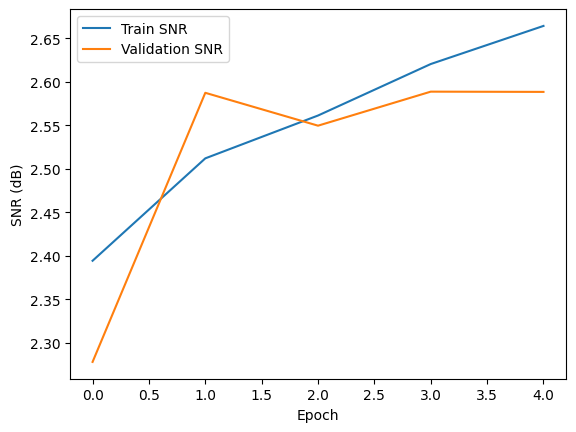

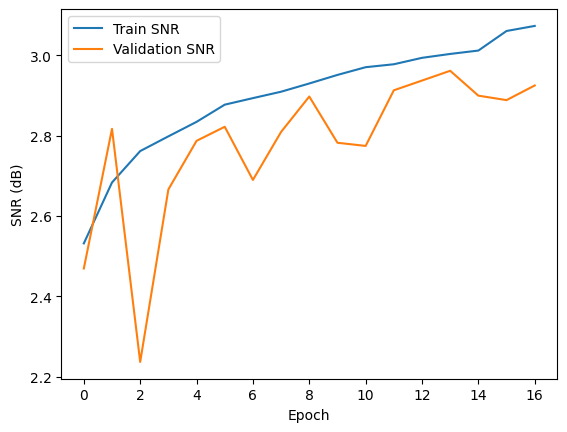

In [23]:
plt.plot(history1["train_snr"], label="Train SNR")
plt.plot(history1["val_snr"], label="Validation SNR")
plt.xlabel("Epoch")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

plt.plot(history2["train_snr"], label="Train SNR")
plt.plot(history2["val_snr"], label="Validation SNR")
plt.xlabel("Epoch")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [10]:
with zipfile.ZipFile('C:\\Users\\Lukas\\Desktop\\TH Nürnberg\\Projekt\\netz\\Daten\\Test_Vocals_Mix_2473.zip', 'r') as zipf:
    zipf.extractall()  # Entpackt alle Dateien
    
    # Lade die Arrays
    X_test = np.load('X_train.npy', allow_pickle=True)
    y_test = np.load('y_train.npy', allow_pickle=True)

print(X_test.shape)
print(y_test.shape)

(2473, 512, 128, 1)
(2473, 512, 128, 1)


In [26]:
# Evaluierung mit den Testdaten im Frequenzbereich

test_snr1 = []
test_snr2 = []
for i in range(len(X_test)):
    print(i, "/", len(X_test), end='\r')
    mask = model1(tf.expand_dims(X_test[i], axis=0), training=False)
    snr = snr_metric_mask(y_test[i], mask, X_test[i])
    test_snr1.append(snr)

    mask2 = model2(tf.expand_dims(X_test[i], axis=0), training=False)
    snr2 = snr_metric_mask(y_test[i], mask2, X_test[i])
    test_snr2.append(snr2)


avg_test_snr1 = np.mean(test_snr1)
avg_test_snr2 = np.mean(test_snr2)
print(f"Test Freq Model 1: SNR = {avg_test_snr1:.4f}, Model 2: SNR = {avg_test_snr2:.4f}")

Test Freq Model 1: SNR = 3.1649, Model 2: SNR = 3.6846


In [19]:
# Evaluierung mit den Testdaten

def combined_freq_time_metric_test(y_true, y_pred, mixture):
    result = y_pred * mixture

    signal_power = tf.reduce_sum(y_true**2)
    noise_power = tf.reduce_sum((y_true - result)**2)

    freq_snr = 10 * tf.math.log(signal_power / (noise_power)) / tf.math.log(10.0)

    time_true = postprocess_simple(y_true)
    time_result = postprocess_simple(result)

    time_signal_power = tf.reduce_sum(time_true**2)
    time_noise_power = tf.reduce_sum((time_true - time_result)**2)

    time_snr = 10 * tf.math.log(time_signal_power / (time_noise_power)) / tf.math.log(10.0)

    return freq_snr, time_snr

test_snr = []
test_freq_snr = []
test_time_snr = []
for i in range(len(X_test)):
    print(i, "/", len(X_test), end='\r')
    mask = model1(tf.expand_dims(X_test[i], axis=0), training=False)
    #snr = snr_metric_mask(y_test[i], mask, X_test[i])

    freq_snr, time_snr = combined_freq_time_metric_test(y_test[i], mask, X_test[i])

    #snr = (freq_snr + time_snr) / 2

    #time_true = postprocess_simple(y_test[i])
    #time_result = postprocess_simple(mask)
    #print(f"{i}: {time_snr}, {time_snr}, {time_snr},")

    #test_snr.append(snr)
    #test_freq_snr.append(freq_snr)
    #test_time_snr.append(time_snr)

    if tf.math.is_finite(freq_snr) and tf.math.is_finite(time_snr):
        snr = (freq_snr + time_snr) / 2
        test_snr.append(snr)
        test_freq_snr.append(freq_snr)
        test_time_snr.append(time_snr)

avg_test_snr = np.mean(test_snr)
avg_test_freq_snr = np.mean(test_freq_snr)
avg_test_time_snr = np.mean(test_time_snr)
print(f"Model 1: Test SNR = {avg_test_snr:.4f}, Freq SNR = {avg_test_freq_snr:.4f}, Time SNR = {avg_test_time_snr:.4f}")

test_snr = []
test_freq_snr = []
test_time_snr = []
for i in range(len(X_test)):
    print(i, "/", len(X_test), end='\r')
    mask = model2(tf.expand_dims(X_test[i], axis=0), training=False)
    #snr = snr_metric_mask(y_test[i], mask, X_test[i])

    freq_snr, time_snr = combined_freq_time_metric_test(y_test[i], mask, X_test[i])

    #snr = (freq_snr + time_snr) / 2

    #time_true = postprocess_simple(y_test[i])
    #time_result = postprocess_simple(mask)
    #print(f"{i}: {time_snr}, {time_snr}, {time_snr},")

    #test_snr.append(snr)
    #test_freq_snr.append(freq_snr)
    #test_time_snr.append(time_snr)

    if tf.math.is_finite(freq_snr) and tf.math.is_finite(time_snr):
        snr = (freq_snr + time_snr) / 2
        test_snr.append(snr)
        test_freq_snr.append(freq_snr)
        test_time_snr.append(time_snr)

avg_test_snr = np.mean(test_snr)
avg_test_freq_snr = np.mean(test_freq_snr)
avg_test_time_snr = np.mean(test_time_snr)
print(f"Model 2: Test SNR = {avg_test_snr:.4f}, Freq SNR = {avg_test_freq_snr:.4f}, Time SNR = {avg_test_time_snr:.4f}")


Model 1: Test SNR = -0.3559, Freq SNR = 2.5548, Time SNR = -3.2667
Model 2: Test SNR = 1.8517, Freq SNR = 3.8063, Time SNR = -0.1028


In [11]:
def preprocess(array, target_size=(512, 128)):
    n_fft = 512
    hop_length = 128
    win_length = 512

    original_max_amplitude = np.max(np.abs(array))
    stft = librosa.stft(array, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    stft_magnitude = np.abs(stft)
    phase = np.angle(stft)

    stft_magnitude = np.nan_to_num(stft_magnitude, nan=0.0, posinf=0.0, neginf=0.0)
    # Prüfen, ob das Array leer oder lautlos ist
    if np.max(stft_magnitude) == 0:  # Kein hörbares Signal
        mag_norm = np.zeros_like(stft_magnitude)
    else:
        mag_norm = stft_magnitude / np.max(stft_magnitude)
    
    # Sicherstellen, dass magnitude ein Tensor ist
    magnitude = tf.convert_to_tensor(mag_norm)
    
    # Füge eine Kanaldimension hinzu, falls nicht vorhanden
    if len(magnitude.shape) == 2:  # Nur Height und Width vorhanden
        magnitude = tf.expand_dims(magnitude, axis=-1)  # -> (Height, Width, 1)
    
    # Resize das Spektrogramm
    magnitude_resized = tf.image.resize(magnitude, target_size)
    return magnitude_resized, phase, original_max_amplitude

def postprocess(after, original_max_amplitude, phase):
    n_fft = 512
    hop_length = 128
    win_length = 512
    after_resized = tf.image.resize(after, (257, 1723))

    after_resized = np.squeeze(after_resized, axis=-1)

    #after_resized = after_resized.numpy()

    after_resized = after_resized * original_max_amplitude

    complex_spectrogram = after_resized * np.exp(1j * phase)
    print(complex_spectrogram.shape)
    audio_reconstructed = librosa.istft(complex_spectrogram, hop_length=hop_length, win_length=win_length)
    #audio_reconstructed = librosa.griffinlim(complex_spectrogram, hop_length=hop_length, win_length=win_length)
    return audio_reconstructed

In [12]:
# Funktionen zum Visualizieren der Waveform und Spectrogram

def show_wav(sources):
    if isinstance(sources, list):
        sources = {f'Source {i}': s for i, s in enumerate(sources)}
    plt.figure(figsize=(10, 5))
    plt.plot()
    nussl.core.utils.visualize_sources_as_waveform(sources)
    plt.show()

def show_1wav(data):
    plt.figure(figsize=(10, 5))
    plt.plot()

    librosa.display.waveshow(data.audio_data, sr = data.sample_rate)
    
    #nussl.core.utils.visualize_waveform(data)
    plt.show()

def show_fre(sources):
    if isinstance(sources, list):
        sources = {f'Source {i}': s for i, s in enumerate(sources)}
    plt.figure(figsize=(10, 5))
    plt.plot()
    nussl.core.utils.visualize_sources_as_masks(sources, db_cutoff=-80)
    plt.tight_layout()
    plt.show()

def show_1fre(data):
    plt.figure(figsize=(10, 5))
    plt.plot()
    nussl.core.utils.visualize_spectrogram(data)
    plt.show()

Abtastrate: 44100, Länge: 200.52678004535147 Sekunden
Model 1:
(257, 1723)


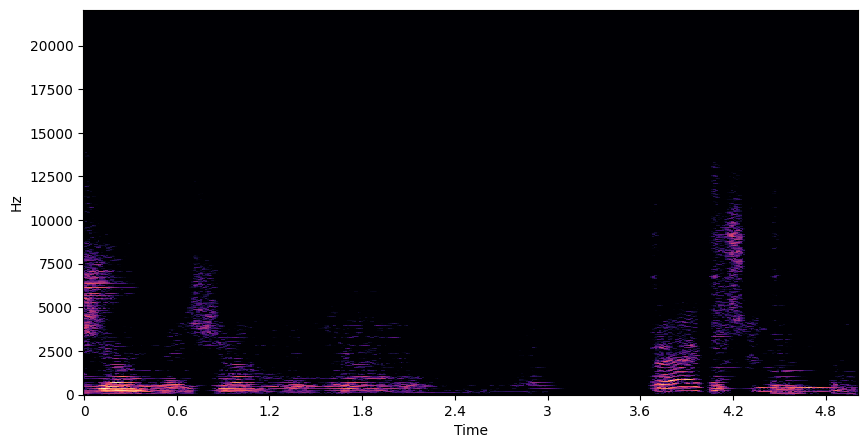

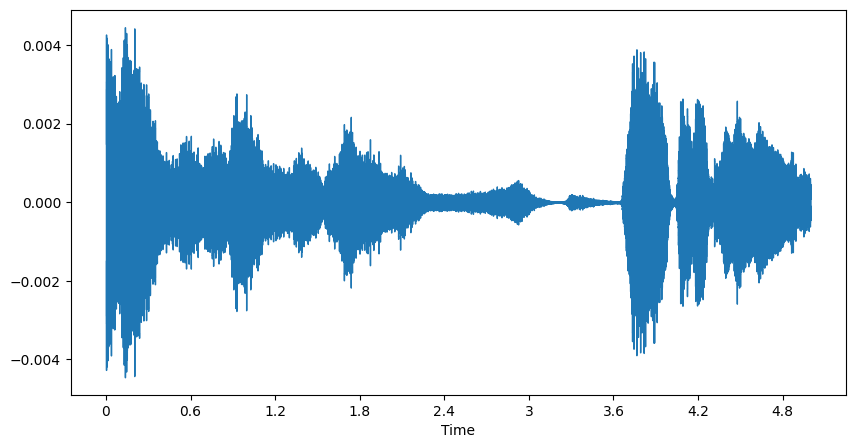

Model 2:
(257, 1723)


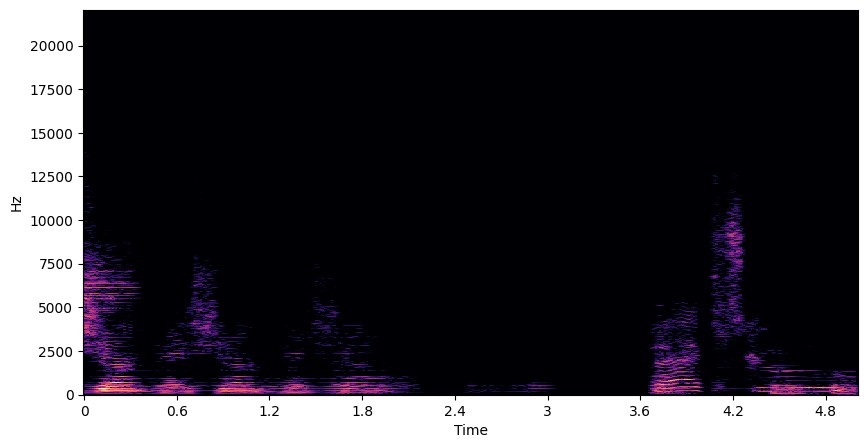

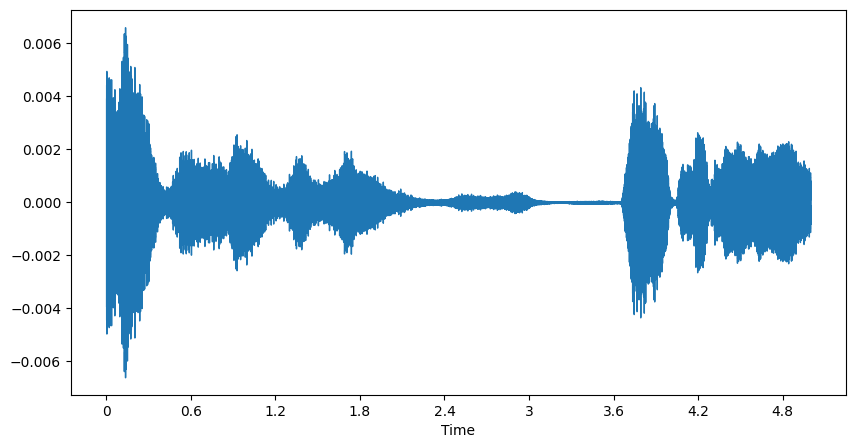

In [24]:
# Test mit Trainingsdaten
path = "C:\\Users\\Lukas\\Desktop\\TH Nürnberg\\Projekt\\musdb18hq\\test\\Al James - Schoolboy Facination\\mixture.wav"

# Audio laden
y, sr = librosa.load(path , sr=None)  # sr=None behält die Original-Abtastrate
print(f"Abtastrate: {sr}, Länge: {len(y) / sr} Sekunden")
#display(Audio(data=y, rate=sr))

s5 = sr * 5

x1 = y[0:s5]
x2 = y[s5:2 * s5]

before = x2  # Ihr Originalsignal
#print(before.shape)

after, ph, max = preprocess(before)
#print(after.shape)

print("Model 1:")
mask = model1(tf.expand_dims(after, axis=0), training=False)
#print(mask.shape)
#mask = np.squeeze(mask, axis=-1)
#print(mask.shape)

neu = mask[0] * after
#neu = mask[0]

vocals = postprocess(neu, max, ph)

song = nussl.AudioSignal()
song.audio_data = vocals
show_1fre(song)
show_1wav(song)
display(Audio(data=song.audio_data, rate=sr))

print("Model 2:")
mask = model2(tf.expand_dims(after, axis=0), training=False)
#print(mask.shape)
#mask = np.squeeze(mask, axis=-1)
#print(mask.shape)

neu = mask[0] * after

vocals = postprocess(neu, max, ph)

song = nussl.AudioSignal()
song.audio_data = vocals
show_1fre(song)
show_1wav(song)
display(Audio(data=song.audio_data, rate=sr))

(257, 1723)
(257, 1723)
Mix:


Vocals:


nach model 1:


nach model 2:


Ziel Amplitudenverlauf:


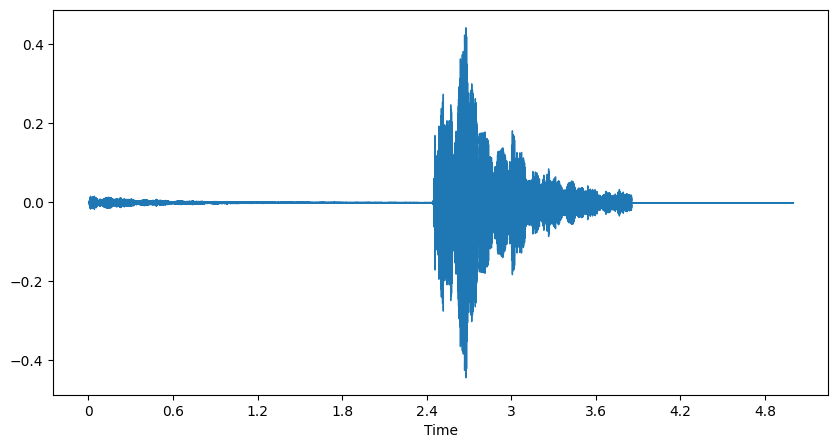

Amplitudenverlauf nach Model 1:


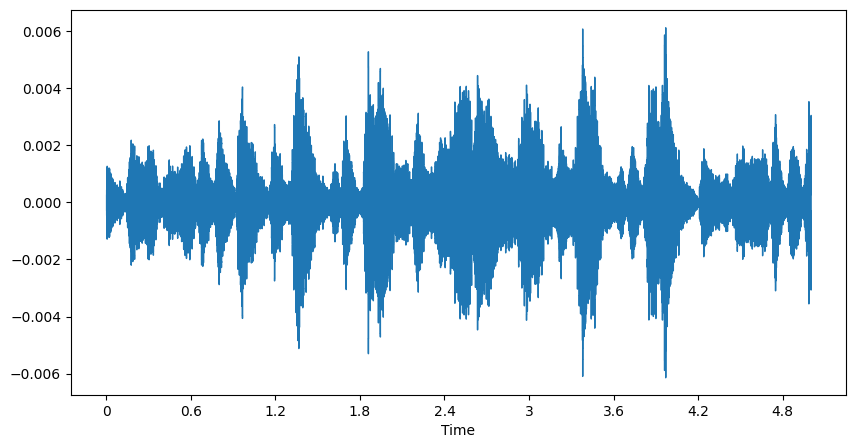

Amplitudenverlauf nach Model 2:


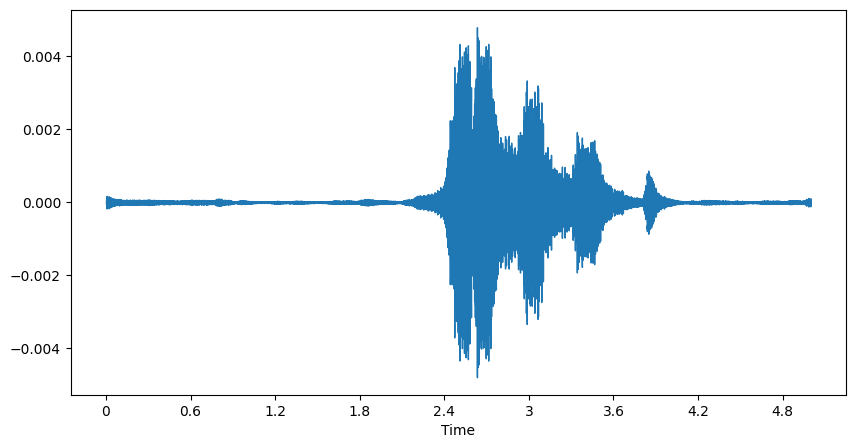

Ziel Spektogram:


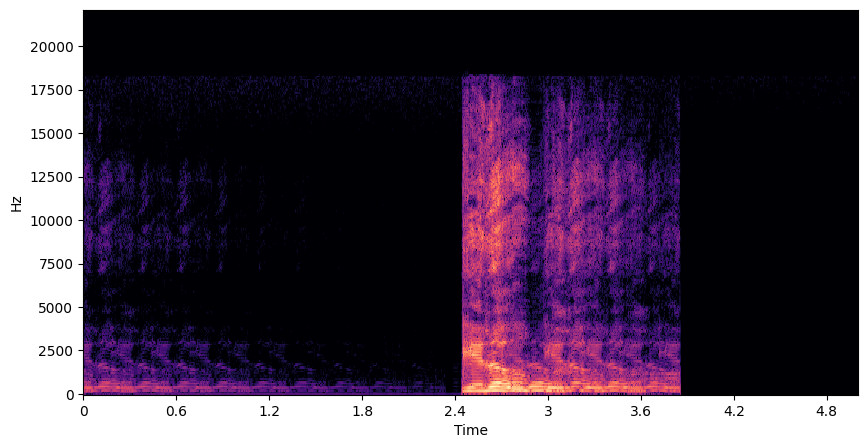

Spektogram nach Model 1:


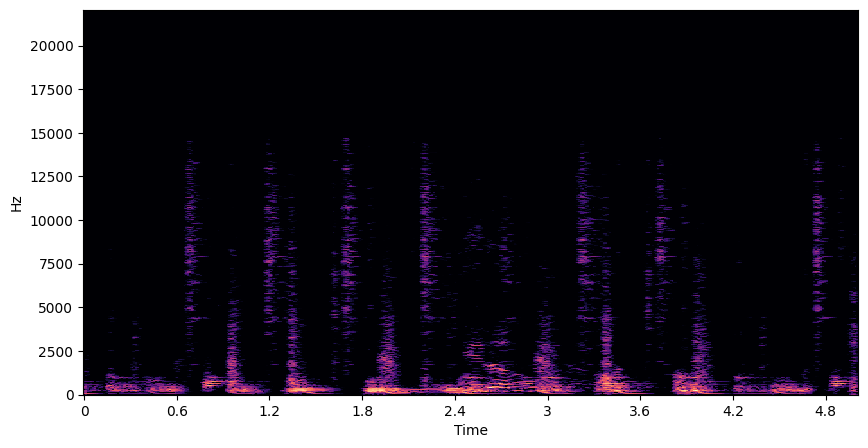

Spektogram nach Model 2:


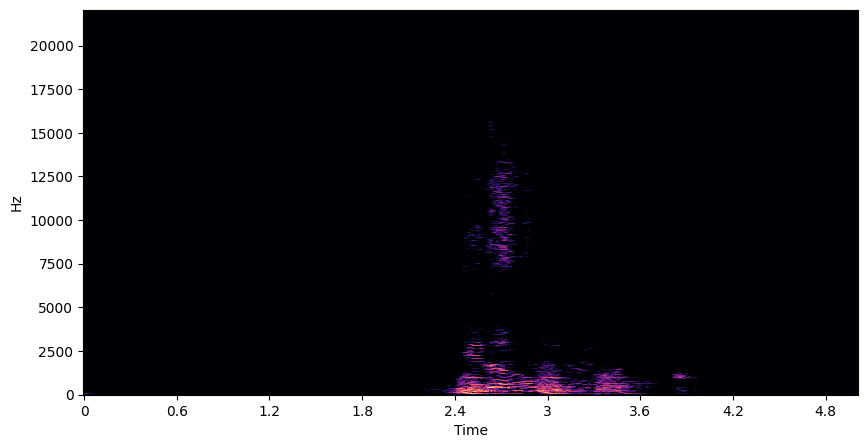

In [25]:
song_id = 15 # 15 20 30

# STFT Parameter setzen
stft_params = nussl.STFTParams(window_length=512, hop_length=128, window_type='sqrt_hann')
#stft_params = nussl.STFTParams(window_length=1024, hop_length=256, window_type='sqrt_hann')

# Pfad zu den Trainingsdaten festlegen
fg_path = "C:\\Users\\Lukas\\nussl_tutorial\\train"

# Trainingsdaten mit `nussl` laden
train_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=2000, coherent_prob=0.1)

# Testdaten laden
test_path = "C:\\Users\\Lukas\\nussl_tutorial\\test"
test_data = data.on_the_fly(stft_params, transform=None, fg_path=test_path, num_mixtures=100)

#song_id = 15
# 15 20 30

test_item = test_data[song_id]
mix = test_item['mix']
mix_array = mix.audio_data[0]
#print(mix_array.shape)
vocals = test_item['sources']['vocals']

mix_mag, ph, max = preprocess(mix_array)

mask1 = model1(tf.expand_dims(mix_mag, axis=0), training=False)
neu1 = mask1[0] * mix_mag
#neu1 = mask1[0]
audi1 = postprocess(neu1, max, ph)
audio_vocal1 = nussl.AudioSignal()
audio_vocal1.audio_data = audi1

mask2 = model2(tf.expand_dims(mix_mag, axis=0), training=False)
neu2 = mask2[0] * mix_mag
audi2 = postprocess(neu2, max, ph)
audio_vocal2 = nussl.AudioSignal()
audio_vocal2.audio_data = audi2

item = test_data[song_id]

# Orginaldaten
print('Mix:')
display(Audio(data=item['mix'].audio_data, rate=item['mix'].sample_rate))
#print(item.keys())
#show_wav(item['sources'])
#show_fre(item['sources'])

print('Vocals:')
display(Audio(data=item['sources']['vocals'].audio_data, rate=item['mix'].sample_rate))

# Audio nach Model
print('nach model 1:')
display(Audio(data=audio_vocal1.audio_data, rate=item['mix'].sample_rate))

print('nach model 2:')
display(Audio(data=audio_vocal2.audio_data, rate=item['mix'].sample_rate))

print('Ziel Amplitudenverlauf:')
show_1wav(data=item['sources']['vocals'])
print('Amplitudenverlauf nach Model 1:')
show_1wav(audio_vocal1)

print('Amplitudenverlauf nach Model 2:')
show_1wav(audio_vocal2)

print('Ziel Spektogram:')
show_1fre(data=item['sources']['vocals'])
print('Spektogram nach Model 1:')
show_1fre(audio_vocal1)

print('Spektogram nach Model 2:')
show_1fre(audio_vocal2)